In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Courses/GBC_MLOps/project_example/notebooks/

/content/drive/MyDrive/Courses/GBC_MLOps/project_example/notebooks


### 1. Импорт необходимых библиотек

In [ ]:
import pandas as pd
import re
import pickle
import numpy as np
import pandas as pd
from typing import Iterator
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

### 2. Дополнительные необходимые функции

In [ ]:
# Загрузка первого словаря с сокращениями
file_dict = open("../references/dict_1.pkl", "rb")
dict_1 = pickle.load(file_dict)
file_dict.close()

In [ ]:
# Загрузка второго словаря с сокращениями
file_dict = open("../references/dict_2.pkl", "rb")
dict_2 = pickle.load(file_dict)
file_dict.close()

In [ ]:
def clean_str(s: str) -> str:
    """
    Функция обработки строки удаляет числа, заменяет сокращения:
    :param s: строка, которую необходимо обработать
    :return: строка с заменой сокращений, удаленными числами
    """
    
    s = s.strip().lower()
    for key in dict_1:
        s = s.replace(key, dict_1[key])
    s = re.sub('[0-9]', ' ', s)
    s = re.sub(" +", " ", s)
    s = re.sub(r'\W+', " ", s)
    arr = np.array(s.split())
    if len(arr) == 0:
        return ''
    for key in dict_2:
        arr = np.where(arr==key, dict_2[key], arr) 
    s = ' '.join(arr)
    return s

def save_txt(texts, labels, file_path, preprocess):
    """
    Вспомогательная функция для create_train_test_files_for_fasttext
    :param texts: набор параметров выборки
    :param labels: вектор меток истинного класса для выборки
    :param file_path: путь к файлу для сохранения результата
    :return: ничего не возвращает, сохраняет датасет в необходимые файлы
    """
    if preprocess: 
        file_path = file_path.split('.txt')[0] + '_prep.txt'
        
    txt_file = open(file_path, "w", encoding='utf-8')

    for i in range(0,len(texts)):
        if preprocess:
            line = '__label__' + str(labels[i]) + ' ' + str(clean_str(texts[i])) + '\n'
        else:
            line = '__label__' + str(labels[i]) + ' ' + str(texts[i]) + '\n'
        txt_file.write(line)
        
    txt_file.close()
    print(file_path + ' created!')
        
def create_train_test_files_for_fasttext(X_train, X_test, y_train, y_test, preprocess = False):
    """
    Функция создания файлов с обучающей и тестовой выборкой, в формате подходящем для обучения модели fasttext:
    :param X_train: набор параметров обучающей выборки
    :param X_test: набор параметров тестовой выборки
    :param y_train: вектор меток истинного класса для обучающей выборки
    :param y_test: вектор меток истинного класса для тестовой выборки
    :return: ничего не возвращает, сохраняет датасет в необходимые файлы
    """
    
    save_txt(X_train, y_train, '../data/processed/train_dataset.txt', preprocess)
    save_txt(X_test, y_test, '../data/processed/test_dataset.txt', preprocess)
    
    return 

### 3. Обрабатываем файл с исходными данными

In [ ]:
data = pd.read_csv('../data/raw/data_checks_v1.csv', index_col=0)

##### 3.1 Приводим необходимые столбцы к типу str нижнего регистра

In [ ]:
data['name'] = data['name'].astype('str').str.lower()
data['category'] = data['category'].astype('str').str.lower()

##### 3.2 Заменяем пробелы на '_' в столбце с названиями категорий

In [ ]:
data['category'] = ['_'.join(cat_name.split(' ')) for cat_name in data['category']]

##### 3.3 Посмотрим гистограмму распределения позиций по классам

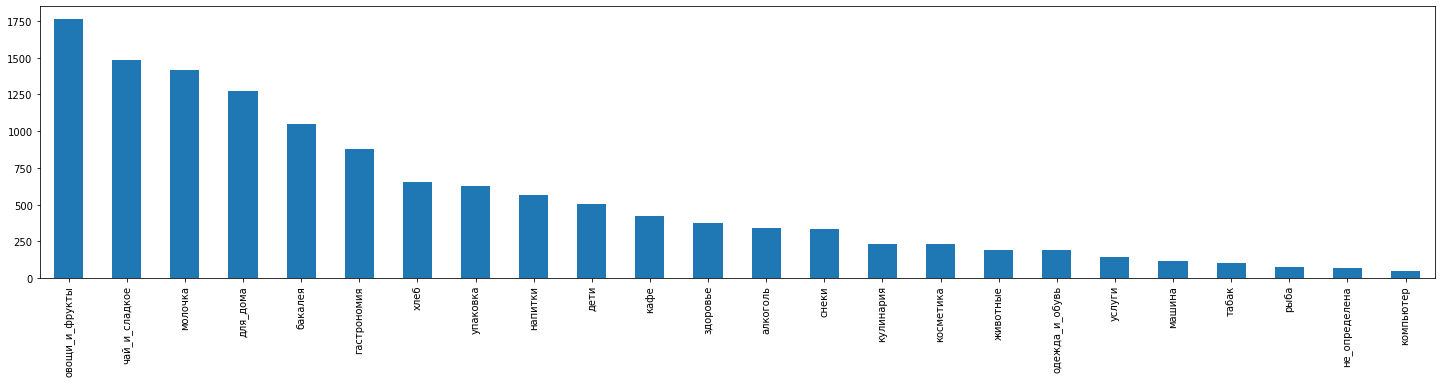

In [ ]:
plt.figure(figsize = (25,5))
data['category'].value_counts().plot(kind = 'bar')

##### 3.4 Запустим нашу функцию предобработки текста clean_str на наименование позиций

In [ ]:
prep_text = []
for text in data.name.values:
    prep_text.append(clean_str(text))
    
data['preprocessed'] = prep_text
data.head()

,check_id,name,category,price,count,preprocessed
0,0,*3479755 тruf.конф.кр.корп.гл.вк.шок180г,чай_и_сладкое,49.0,2.0,тruf конф кр корп гл вк шоколадный грамм
1,0,3408392 econta мешки д/мусора 30л 30шт,для_дома,21.0,1.0,econta мешки д мусора литр штука
2,0,3260497 яшкино рулет с вар.сгущ. 200г,чай_и_сладкое,39.0,1.0,яшкино рулет с вареная сгущ грамм
3,0,3300573 пакет пятерочка 65х40см,упаковка,4.0,1.0,пакет пятерочка х см
4,0,3413607 зер/сел.сухари с изюмом 250г,чай_и_сладкое,35.0,1.0,зер сел сухари с изюмом грамм


##### 3.5 Разделим все данные на обучающую и тестовую выборки

Данные из каждого класса должны попасть и в обучающую, и в тестовую выборки, поэтому используем параметр stratify

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.preprocessed, data.category,
                                                    stratify=data.category, 
                                                    test_size=0.30,
                                                    shuffle=True)

##### 3.6 Проверим разделение выборки, для этого посмотрим на гистограмму

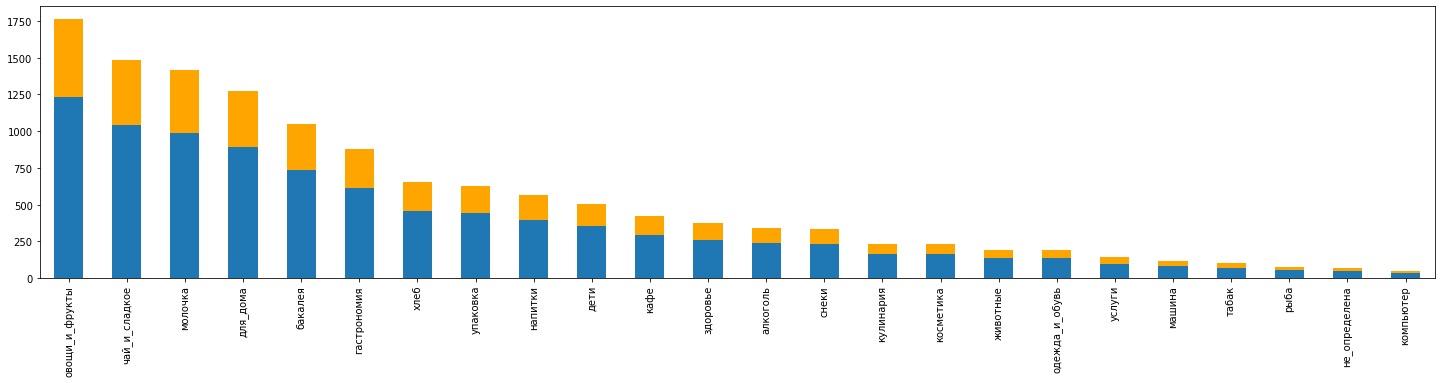

In [ ]:
plt.figure(figsize = (25,5))
y_train.value_counts().plot(kind = 'bar', alpha=1)
y_test.value_counts().plot(kind = 'bar', alpha=1, color = 'orange', bottom = y_train.value_counts())

##### 3.7 Сохраняем датасеты в формате для обучения модели fasttext

In [ ]:
create_train_test_files_for_fasttext(
    X_train.values, X_test.values, 
    y_train.values, y_test.values, 
    preprocess = True)

../data/processed/train_dataset_prep.txt created!
../data/processed/test_dataset_prep.txt created!


##### 3.8 Сохраняем датасеты в формате csv для удобства тестирования

In [ ]:
train = pd.DataFrame([X_train, y_train]).T
train.to_csv('../data/processed/train_dataset_prep.csv')

test = pd.DataFrame([X_test, y_test]).T
test.to_csv('../data/processed/test_dataset_prep.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 6113 to 3664
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   preprocessed  3925 non-null   object
 1   category      3925 non-null   object
dtypes: object(2)
memory usage: 221.0+ KB


In [ ]:
data = pd.read_csv('../data/processed/test_dataset_prep.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 6113 to 3664
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   preprocessed  3920 non-null   object
 1   category      3925 non-null   object
dtypes: object(2)
memory usage: 92.0+ KB
